In [48]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.ml.feature import (
    Imputer,
    StringIndexer,
    VectorAssembler,
    StandardScaler,
)
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Starting a spark session

In [49]:
spark = SparkSession.builder.appName("Customer churn project").getOrCreate()

Reading the dataset

In [50]:
data = (
    spark.read.format("csv")
    .option("inferSchema", True)
    .option("header", True)
    .load("../data/churn_dataset.csv")
)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Looking at the schema of the dataset

In [51]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Looking at the number of rows and columns of the dataset

In [52]:
_ = f"Rows : {data.count()}, Columns : {len(data.columns)}"
_

'Rows : 7043, Columns : 21'

Get all the numerical values, storing in a **pandas** dataframe and visualizing the features

- Reason : **pyspark** stores data on distributed servers, we need to assemble all of it at one place on our local drive.

In [53]:
numerical_columns = [
    name for name, typ in data.dtypes if typ == "double" or typ == "int"
]
numerical_data = data.select(numerical_columns)
df_numerical = numerical_data.toPandas()
df_numerical.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

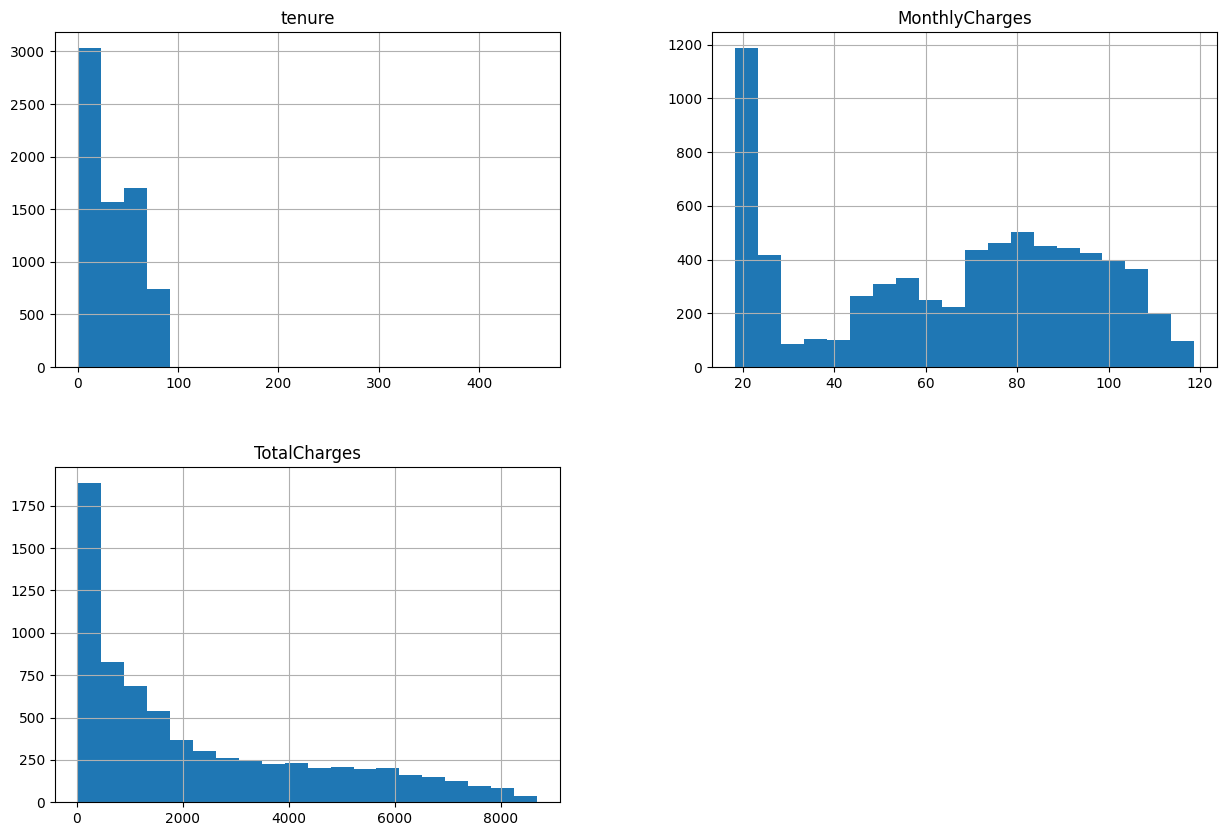

In [54]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
df_numerical.hist(ax=ax, bins=20)

Checking the correlation matrix of numerical values

- Total charges has high correlation with other two features

In [55]:
df_numerical.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Clean and preprocess the data

In [56]:
for column in numerical_columns:
    data.select(count(when(col(column).isNull(), column)).alias(column)).show()

+------+
|tenure|
+------+
|     0|
+------+

+--------------+
|MonthlyCharges|
+--------------+
|             0|
+--------------+

+------------+
|TotalCharges|
+------------+
|          11|
+------------+



Imputing the missing values in **TotalCharges** column

In [57]:
columns_with_missing_values = ["TotalCharges"]
imputer = Imputer(
    inputCols=columns_with_missing_values, outputCols=columns_with_missing_values
).setStrategy("mean")

In [58]:
imputer = imputer.fit(data)
data = imputer.transform(data)
data.select(
    count(when(col("TotalCharges").isNull(), "TotalCharges")).alias("TotalCharges")
).show()

+------------+
|TotalCharges|
+------------+
|           0|
+------------+



Removing the outliers

In [59]:
data.select("*").where(data.tenure > 100).show()
# This is outlier

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [60]:
data = data.filter(data.tenure < 100)

Feature Preparation

- pySpark does not take individual columns of features for ML purpose. Rather, it needs all of them to be assembled. We will do it using `Vector Assembling ==> Standard Scalar`
- Similar for categorical variables, however, we will use `String Indexing ==> Vector Assembling`

In [61]:
# Numerical
numerical_vector_assemblers = VectorAssembler(
    inputCols=numerical_columns, outputCol="numerical_features_vector"
)
data = numerical_vector_assemblers.transform(data)
scaler = StandardScaler(
    inputCol="numerical_features_vector",
    outputCol="numerical_features_scaled",
    withStd=True,
    withMean=True,
)
data = scaler.fit(data).transform(data)

In [62]:
# Categorical
categorical_columns = [name for name, typ in data.dtypes if typ == "string"]
categorical_columns_indexed = [f"{name}_indexed" for name in categorical_columns]

str_indexer = StringIndexer(
    inputCols=categorical_columns, outputCols=categorical_columns_indexed
)
data = str_indexer.fit(data).transform(data)

# removing customerID and target column to not pass to vector assembler
categorical_columns_indexed.remove("customerID_indexed")
categorical_columns_indexed.remove("Churn_indexed")


categorical_vector_assemblers = VectorAssembler(
    inputCols=categorical_columns_indexed, outputCol="categorical_features_vector"
)
data = categorical_vector_assemblers.transform(data)

Combine the numerical and categorical vectors

In [63]:
final_vector_assembler = VectorAssembler(
    inputCols=["categorical_features_vector", "numerical_features_scaled"],
    outputCol="final_feature_vector",
)
data = final_vector_assembler.transform(data)

ml_ready_data = data.select(["final_feature_vector", "Churn_indexed"])
ml_ready_data = ml_ready_data.selectExpr(
    "final_feature_vector as final_feature_vector", "Churn_indexed as true"
)
ml_ready_data.show()

+--------------------+----+
|final_feature_vector|true|
+--------------------+----+
|(19,[0,2,4,5,6,8,...| 0.0|
|(19,[6,7,9,13,14,...| 0.0|
|(19,[6,7,8,15,16,...| 1.0|
|[0.0,0.0,0.0,0.0,...| 0.0|
|(19,[0,16,17,18],...| 1.0|
|(19,[0,5,9,11,12,...| 1.0|
|(19,[3,5,8,11,15,...| 0.0|
|(19,[0,4,5,6,7,14...| 0.0|
|(19,[0,2,5,9,10,1...| 1.0|
|(19,[3,6,7,8,13,1...| 0.0|
|(19,[2,3,6,7,15,1...| 0.0|
|[0.0,0.0,0.0,0.0,...| 0.0|
|(19,[2,5,9,11,12,...| 0.0|
|(19,[5,8,9,11,12,...| 1.0|
|(19,[7,9,10,11,12...| 0.0|
|[1.0,0.0,1.0,1.0,...| 0.0|
|[1.0,0.0,0.0,0.0,...| 0.0|
|[0.0,0.0,0.0,1.0,...| 0.0|
|(19,[0,2,3,6,9,10...| 1.0|
|(19,[0,8,9,12,16,...| 0.0|
+--------------------+----+
only showing top 20 rows


Model Training

In [64]:
train, test = ml_ready_data.randomSplit([0.7, 0.3], seed=100)
train.count(), test.count()

(4930, 2112)

In [65]:
dt = DecisionTreeClassifier(
    featuresCol="final_feature_vector", labelCol="true", maxDepth=3
)
model = dt.fit(train)

In [66]:
prediction_test = model.transform(test)
prediction_test.select(["true", "prediction"]).show()

+----+----------+
|true|prediction|
+----+----------+
| 0.0|       0.0|
| 1.0|       1.0|
| 0.0|       0.0|
| 1.0|       0.0|
| 1.0|       1.0|
| 0.0|       0.0|
| 0.0|       0.0|
| 0.0|       0.0|
| 0.0|       0.0|
| 1.0|       0.0|
| 1.0|       0.0|
| 1.0|       1.0|
| 0.0|       0.0|
| 0.0|       0.0|
| 1.0|       1.0|
| 1.0|       1.0|
| 1.0|       0.0|
| 0.0|       0.0|
| 1.0|       1.0|
| 1.0|       0.0|
+----+----------+
only showing top 20 rows


Hyperparameter tuning

In [67]:
evaluator = BinaryClassificationEvaluator(labelCol="true")
auc_test = evaluator.evaluate(prediction_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7684224298730984

In [68]:
prediction_train = model.transform(train)
auc_train = evaluator.evaluate(prediction_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.7765707557926191

In [69]:
def evaluate_dt(maxD):
    # train the model based on the maxD
    decision_tree = DecisionTreeClassifier(
        featuresCol="final_feature_vector", labelCol="true", maxDepth=maxD
    )
    dtModel = decision_tree.fit(train)

    # calculating test error
    predictions_test = dtModel.transform(test)
    evaluator = BinaryClassificationEvaluator(labelCol="true")
    auc_test = evaluator.evaluate(
        predictions_test, {evaluator.metricName: "areaUnderROC"}
    )
    # recording the accuracy

    # calculating training error
    predictions_training = dtModel.transform(train)
    evaluator = BinaryClassificationEvaluator(labelCol="true")
    auc_training = evaluator.evaluate(
        predictions_training, {evaluator.metricName: "areaUnderROC"}
    )

    return (auc_test, auc_training)


max_depths = range(2, 21, 1)
auc_test_all = []
auc_train_all = []

for maxD in tqdm(max_depths, desc="Evaluating hyperparameter maxD"):
    auc_testing, auc_training = evaluate_dt(maxD)
    auc_test_all.append(auc_testing)
    auc_train_all.append(auc_training)

df = pd.DataFrame()
df["maxD"] = list(max_depths)
df["test_error"] = list(auc_test_all)
df["train_error"] = list(auc_train_all)

px.line(df, x="maxD", y=["test_error", "train_error"])

Evaluating hyperparameter maxD: 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Checking feature importance

In [70]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(
    scores, columns=["score"], index=categorical_columns_indexed + numerical_columns
)
px.bar(df, y="score")

We see that contract_indexed has highest score in prediction. Let us see what is the impact of each category of cotnract on the churn.

In [71]:
df = data.groupby("Contract", "Churn").count().toPandas()
px.bar(df, x="Contract", y="count", color="Churn")

Suggestion:

Month to month customers have high churn while 2 years have very low churn. the company can offer the clients two year plan in stead of month to month to decrease the churn.